In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import category_encoders as ce
import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

Đọc dữ liệu và tạo khung dữ liệu

In [140]:
df = pd.read_csv('data/new_data.csv')
df.head(1)

jobId                      jobTitle                 approvedOn  \
0  1680760  Nhân Viên Kinh Doanh MT - GT  2023-08-11T11:22:45+07:00   

                  companyName  isAnonymous  isSalaryVisible  \
0  Công Ty Cổ Phần S77 Hà Nội        False             True   

                                      jobDescription  \
0  1. Doanh số bán hàng\n- Thực hiện bán hàng the...   

                                      jobRequirement  jobLevelId  salary  ...  \
0  - Ít nhất 1 năm kinh nghiệm ở vị trí tương đươ...           5     700  ...   

   address                                         industries  \
0   Hà Nội  {11: 'Customer Service', 32: 'Retail/Wholesale...   

                    jobLevel jobLevelVI companySize languageSelected  \
0  Experienced (non-manager)  Nhân viên    (10, 24)              Any   

  prettySalary durationDays numOfApplications typeWorkingName  
0  $500 - $700           30                 0       Full-time  

[1 rows x 26 columns]

In [141]:
temp_df = df.copy()

Xử lý dữ liệu trước khi mô hình hóa dữ liệu

In [142]:
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8972 entries, 0 to 8971
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   jobId              8972 non-null   int64 
 1   jobTitle           8972 non-null   object
 2   approvedOn         8972 non-null   object
 3   companyName        8972 non-null   object
 4   isAnonymous        8972 non-null   bool  
 5   isSalaryVisible    8972 non-null   bool  
 6   jobDescription     8970 non-null   object
 7   jobRequirement     8972 non-null   object
 8   jobLevelId         8972 non-null   int64 
 9   salary             8972 non-null   int64 
 10  salaryMax          8972 non-null   int64 
 11  salaryMin          8972 non-null   int64 
 12  typeWorkingId      8972 non-null   int64 
 13  skills             8972 non-null   object
 14  benefits           8972 non-null   object
 15  workingLocations   8972 non-null   object
 16  address            8780 non-null   object


companySize

In [143]:
#chuyển cột companySize sang numberic
def process_companySize(x):
    if not isinstance (x, float):
        x_str = str(x).replace('(','').replace(')','')
        sizes = x_str.split(',')
        int_sizes = [int(size) for size in sizes]
        return np.mean(int_sizes)
    else:
        return np.nan
temp_df['companySize'] = temp_df['companySize'].apply(process_companySize) 

In [144]:
#kiểm tra cột có giá trị thiếu
if temp_df['companySize'].isnull().any():
    print("có")
else:
    print("không")

không


In [145]:
#Sau khi ktra có giá trị thiếu bổ sung, dùng median lấy giá trị trung bình
median_size = temp_df['companySize'].median()
temp_df['companySize'] = temp_df['companySize'].fillna(median_size)

Salary

In [146]:
#tính trung vị cho cột Salary sau đó thay thế các giá trị salary = 0 trong cột
median_salary = temp_df['salary'].loc[temp_df['salary'] > 0].median()
temp_df['salary'] = temp_df['salary'].replace(to_replace = 0, value = median_salary)

numOfApplications

In [147]:
#tính giá trị trung bình và thay các giá trị = 0 bằng gí trị đã tính
mean_val = temp_df['numOfApplications'].mean()
temp_df.loc[temp_df['numOfApplications'] == 0, 'numOfApplications'] = int(mean_val)

In [148]:
#Thay thế các giá trị 0 trong cột 'salaryMax' bằng giá trị tương ứng từ cột 'salaryMin'
temp_df.loc[temp_df['salaryMax'] == 0, 'salaryMax'] = temp_df.loc[temp_df['salaryMax'] == 0, 'salaryMin']

In [149]:
#chọn các cột cần thiết
temp_df = temp_df[['typeWorkingName','companySize','jobLevel','numOfApplications','languageSelected',\
                    'industries','workingLocations','benefits','skills','salary','approvedOn']]
temp_df 

typeWorkingName  companySize                   jobLevel  \
0          Full-time         17.0  Experienced (non-manager)   
1          Full-time         62.0  Experienced (non-manager)   
2          Full-time         17.0  Experienced (non-manager)   
3          Full-time        299.5  Experienced (non-manager)   
4          Full-time        299.5  Experienced (non-manager)   
...              ...          ...                        ...   
8967       Full-time        749.5  Experienced (non-manager)   
8968       Full-time        749.5  Experienced (non-manager)   
8969       Full-time         62.0  Experienced (non-manager)   
8970       Full-time        749.5  Experienced (non-manager)   
8971       Full-time        749.5  Experienced (non-manager)   

      numOfApplications languageSelected  \
0                    33              Any   
1                    33          English   
2                    33              Any   
3                    33              Any   
4                    33       Vietnamese   
...                 ...              ...   
8967                  7              Any   
8968                  7              Any   
8969                  4              Any   
8970                  6              Any   
8971                  6          English   

                                             industries  workingLocations  \
0     {11: 'Customer Service', 32: 'Retail/Wholesale...    {24: 'Hà Nội'}   
1     {3: 'Advertising/Promotion/PR', 27: 'Marketing...    {24: 'Hà Nội'}   
2     {1: 'Accounting', 58: 'Auditing', 59: 'Finance...    {24: 'Hà Nội'}   
3     {3: 'Advertising/Promotion/PR', 27: 'Marketing...    {24: 'Hà Nội'}   
4     {33: 'Sales', 42: 'Banking', 59: 'Finance/Inve...    {24: 'Hà Nội'}   
...                                                 ...               ...   
8967  {8: 'Consulting', 58: 'Auditing', 69: 'Plannin...    {24: 'Hà Nội'}   
8968  {8: 'Consulting', 58: 'Auditing', 69: 'Plannin...    {24: 'Hà Nội'}   
8969     {19: 'Export-Import', 36: 'Freight/Logistics'}  {37: 'Lạng Sơn'}   
8970  {8: 'Consulting', 11: 'Customer Service', 58: ...    {24: 'Hà Nội'}   
8971  {8: 'Consulting', 58: 'Auditing', 59: 'Finance...    {24: 'Hà Nội'}   

                                               benefits  \
0     {1: 'Bonus', 2: 'Healthcare Plan', 10: 'Team A...   
1     {1: 'Bonus', 2: 'Healthcare Plan', 4: 'Training'}   
2     {1: 'Bonus', 2: 'Healthcare Plan', 10: 'Team A...   
3     {1: 'Bonus', 2: 'Healthcare Plan', 9: 'Travel ...   
4              {1: 'Bonus', 4: 'Training', 5: 'Awards'}   
...                                                 ...   
8967            {1: 'Bonus', 5: 'Awards', 15: 'Others'}   
8968            {1: 'Bonus', 5: 'Awards', 15: 'Others'}   
8969  {2: 'Healthcare Plan', 3: 'Paid Leave', 10: 'T...   
8970            {1: 'Bonus', 5: 'Awards', 15: 'Others'}   
8971            {1: 'Bonus', 5: 'Awards', 15: 'Others'}   

                                                 skills  salary  \
0     {1919: 'Kênh MT', 1921: 'Hàng Tiêu Dùng', 666:...     700   
1     {27810: 'Marketing Materials Strategy', 333851...    1000   
2     {93: 'Kế Toán Tổng Hợp', 941661: 'Hạch Toán Ch...     700   
3     {100: 'English', 651: 'Trade Marketing', 15900...    1000   
4     {17750: 'Tìm Kiếm Khách Hàng', 354: 'Chăm Sóc ...    1000   
...                                                 ...     ...   
8967  {618943: 'Government Organizations', 236965: '...    1500   
8968  {618943: 'Government Organizations', 941031: '...    1000   
8969  {67: 'Xuất Nhập Khẩu', 26367: 'Booking', 23667...    1000   
8970  {9428: 'Chinese', 346516: 'Business Deveplomen...    1000   
8971  {184: 'Risk', 29886: 'Business consulting', 16...    1000   

                     approvedOn  
0     2023-08-11T11:22:45+07:00  
1     2023-08-11T11:20:32+07:00  
2     2023-08-11T11:17:28+07:00  
3     2023-08-11T11:10:02+07:00  
4     2023-08-10T10:43:12+07:00  
...                         ...  
8967  2023-07-22T17:06:30+07:0

In [150]:
#tìm ngày gần nhất trong cột approvedOn sau đó tính ra số giờ của bài đăng 
newest_date = temp_df['approvedOn'].max()
temp_df['approvedOn'] = temp_df['approvedOn'].apply(lambda x : round((datetime.datetime.fromisoformat(newest_date).timestamp() - datetime.datetime.fromisoformat(x).timestamp())/3600,0))

In [151]:
#sử dụng để biến đổi mã nhị phân từ văn bản hoặc nhãn
mlb = MultiLabelBinarizer()

In [152]:
#chuyển đỗi dữ liệu sang chuỗi nhị phân
encoded_industries = mlb.fit_transform(temp_df['industries'])
encoded_industries_df = pd.DataFrame(encoded_industries, columns=mlb.classes_)

encoded_skills = mlb.fit_transform(temp_df['skills'])
encoded_skills_df = pd.DataFrame(encoded_skills, columns = mlb.classes_)

encoded_workingLocations = mlb.fit_transform(temp_df['workingLocations'])
encoded_workingLocations_df = pd.DataFrame(encoded_workingLocations, columns = mlb.classes_)

encoded_benefits = mlb.fit_transform(temp_df['benefits'])
encoded_benefits_df = pd.DataFrame(encoded_benefits, columns = mlb.classes_)

#tạo df mới từ dữ liệu trên bằng cách kết hợp với df cũ và loại bỏ các cột không cần thiết
encoded_1_df = pd.concat([temp_df.reset_index(), encoded_industries_df,encoded_skills_df,\
    encoded_workingLocations_df,encoded_benefits_df],axis = 1)
encoded_1_df = encoded_1_df.drop(['industries','skills','workingLocations','benefits','index'],axis = 1)
encoded_1_df

typeWorkingName  companySize                   jobLevel  \
0          Full-time         17.0  Experienced (non-manager)   
1          Full-time         62.0  Experienced (non-manager)   
2          Full-time         17.0  Experienced (non-manager)   
3          Full-time        299.5  Experienced (non-manager)   
4          Full-time        299.5  Experienced (non-manager)   
...              ...          ...                        ...   
8967       Full-time        749.5  Experienced (non-manager)   
8968       Full-time        749.5  Experienced (non-manager)   
8969       Full-time         62.0  Experienced (non-manager)   
8970       Full-time        749.5  Experienced (non-manager)   
8971       Full-time        749.5  Experienced (non-manager)   

      numOfApplications languageSelected  salary  approvedOn     &  '  ...  p  \
0                    33              Any     700         0.0  1  0  1  ...  0   
1                    33          English    1000         0.0  1  0  1  ...  0   
2                    33              Any     700         0.0  1  0  1  ...  0   
3                    33              Any    1000         0.0  1  0  1  ...  1   
4                    33       Vietnamese    1000        25.0  1  0  1  ...  0   
...                 ...              ...     ...         ... .. .. ..  ... ..   
8967                  7              Any    1500       474.0  1  0  1  ...  0   
8968                  7              Any    1000       474.0  1  0  1  ...  0   
8969                  4              Any    1000       480.0  1  0  1  ...  0   
8970                  6              Any    1000       475.0  1  0  1  ...  0   
8971                  6          English    1000       475.0  1  0  1  ...  0   

      r  s  t  u  v  w  y  {  }  
0     1  1  1  1  1  0  0  1  1  
1     1  1  1  1  0  0  0  1  1  
2     1  1  1  1  1  0  0  1  1  
3     1  1  1  1  1  0  0  1  1  
4     1  1  0  1  0  1  0  1  1  
...  .. .. .. .. .. .. .. .. ..  
8967  1  1  1  1  0  1  0  1  1  
8968  1  1  1  1  0  1  0  1  1  
8969  1  1  1  0  1  0  0  1  1  
8970  1  1  1  1  0  1  0  1  1  
8971  1  1  1  1  0  1  0  1  1  

[8972 rows x 363 columns]

In [153]:
#dùng thư viện category_encoders mã hóa các biến phân loại thành số nguyên
encoder = ce.CountEncoder(cols=['jobLevel', 'typeWorkingName','languageSelected'])
encoded = encoder.fit_transform(encoded_1_df)

In [154]:
#kết hợp với df cũ sau đó cũng xóa nhưng cột không cần thiết
encoded_df = encoded_1_df.drop(['typeWorkingName', 'jobLevel', 'languageSelected'],axis = 1)
encoded_df = pd.concat([encoded_df, encoded[['jobLevel', 'typeWorkingName','languageSelected']]],axis = 1)
# encoded_df = encoded_df.drop(['index'],axis = 1)
encoded_df

companySize  numOfApplications  salary  approvedOn     &  '  ,  -  /  \
0            17.0                 33     700         0.0  1  0  1  1  0  1   
1            62.0                 33    1000         0.0  1  0  1  1  0  1   
2            17.0                 33     700         0.0  1  0  1  1  0  1   
3           299.5                 33    1000         0.0  1  0  1  1  0  1   
4           299.5                 33    1000        25.0  1  0  1  1  0  1   
...           ...                ...     ...         ... .. .. .. .. .. ..   
8967        749.5                  7    1500       474.0  1  0  1  1  0  1   
8968        749.5                  7    1000       474.0  1  0  1  1  0  1   
8969         62.0                  4    1000       480.0  1  0  1  1  1  1   
8970        749.5                  6    1000       475.0  1  0  1  1  0  0   
8971        749.5                  6    1000       475.0  1  0  1  1  0  1   

      ...  t  u  v  w  y  {  }  jobLevel  typeWorkingName  languageSelected  
0     ...  1  1  1  0  0  1  1      5956             8848              6189  
1     ...  1  1  0  0  0  1  1      5956             8848              2223  
2     ...  1  1  1  0  0  1  1      5956             8848              6189  
3     ...  1  1  1  0  0  1  1      5956             8848              6189  
4     ...  0  1  0  1  0  1  1      5956             8848               422  
...   ... .. .. .. .. .. .. ..       ...              ...               ...  
8967  ...  1  1  0  1  0  1  1      5956             8848              6189  
8968  ...  1  1  0  1  0  1  1      5956             8848              6189  
8969  ...  1  0  1  0  0  1  1      5956             8848              6189  
8970  ...  1  1  0  1  0  1  1      5956             8848              6189  
8971  ...  1  1  0  1  0  1  1      5956             8848              2223  

[8972 rows x 363 columns]

Lựa chọn đặc trưng \
Lựa chọn đặc trưng bằng dữ liệu số

In [155]:
numeric_df = encoded_df[['numOfApplications','salary','companySize','approvedOn']]
corr = numeric_df.corr()
corr

numOfApplications    salary  companySize  approvedOn
numOfApplications           1.000000  0.020938    -0.010881    0.211782
salary                      0.020938  1.000000     0.007306   -0.028660
companySize                -0.010881  0.007306     1.000000    0.022777
approvedOn                  0.211782 -0.028660     0.022777    1.000000

Sử dụng biểu đồ heatmap để mô tả mối tương quan giữa các cột

<Axes: >

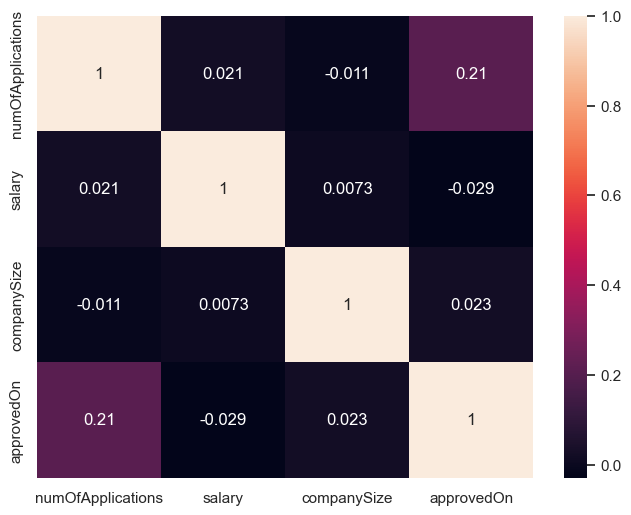

In [156]:
sns.set_theme()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True)

=> Bỏ cột numofApplications vì mối tương quan giữa lương và nó rất nhỏ

Lựa chọn đặc trưng bằng dữ liệu phân loại


<Axes: >

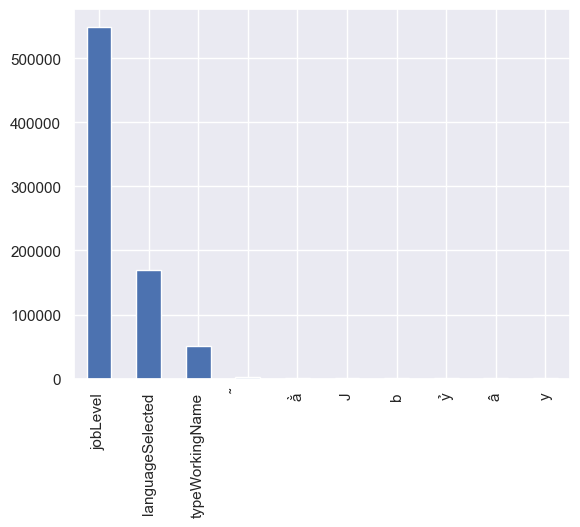

In [178]:
categorical_df = encoded_df.drop(['numOfApplications','salary','companySize','approvedOn'],axis = 1)
target = encoded_df['salary']
chi_scores = chi2(categorical_df, target)
chi_values = pd.Series(chi_scores[0], index=categorical_df.columns)
chi_values = chi_values.sort_values(ascending=False)
chi_values[:10].plot.bar()

<Axes: >

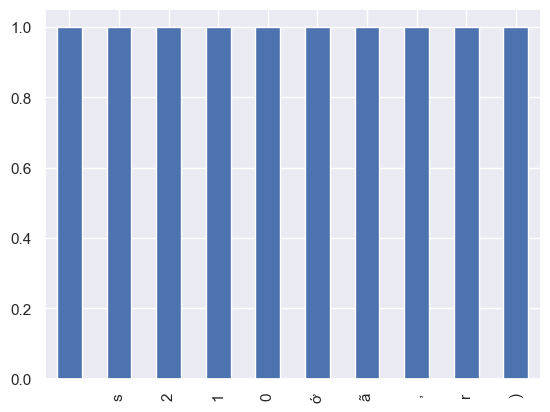

In [159]:
p_values = pd.Series(chi_scores[1], index=categorical_df.columns)
p_values = p_values.sort_values(ascending=False)
p_values[:10].plot.bar()

In [160]:
lower_importance_columns = p_values[p_values.values > 0.05].index.values
lower_importance_columns

array([' ', 's', '2', '1', '0', 'ớ', 'ã', ',', 'r', ')', '(', "'", ' ',
       '4', '}', '{', 'u', '{', 't', '}', "'", 't', 's', 'r', '3', '5',
       'p', '}', 'r', 'o', 'm', 'n', ' ', 'k', 'a', 'i', 'o', '{', 'g',
       '6', 'h', 'i', 'e', 'n', 'o', 'q', ':', '9', '8', '7', 'Â', 'o',
       'n', 'ệ', 'ầ', ',', "'", 'ẳ', 'ằ', 'B', ' ', 'ề', ':', ':', 'ﬁ',
       '{', 'Ề', 'ỳ', 'ỉ', '1', 'Ố', 'ỡ', '/', '}', ',', "'", 'ẫ', '2',
       'a', 'A', 'Ý', 'H', 'e', 'i', 'u', 'e', 'Ă', 'đ', 'Ầ', 'ớ', 'a',
       ':', 'ô', '̀', 'ă', '́', 'c', 'ù', 't', '6', 'y', 'Ấ', 'g', 'r',
       'i', 'S', 'ú', 'C', '̉', 'l', 'c', 'ủ', 'ừ', 'l', 'P', 'ĩ', 'u',
       'D', 'h', 'ả', '8', 'm', 'T', '2', 'ắ', 'ó', 'D', 'ì', 'B', '7',
       'p', '5', 'ậ', 'd', 'm', 'ò', 'e', 'ọ', 'ư', 'ừ', '4', 'j', 'T',
       'c', 'O', 'ơ', 'K', 'v', 'Y', 'á', 'N', 'õ', '2', 's', 'n', 'v',
       '6', '7', 'B', '6', 'I', 'x', 'h', 'P', 'E', 'L', 'd', '&', 'ê',
       'H', 'M', 'h', 'p', 'Ả', 'ở', 'W', 'E', 'y', '9', 'Ẩ', 'ộ

In [161]:
final_df = encoded_df.drop(columns=lower_importance_columns, axis=1)
final_df

companySize  numOfApplications  salary  approvedOn  J  #  +  .  J  Z  \
0            17.0                 33     700         0.0  0  0  0  0  0  0   
1            62.0                 33    1000         0.0  0  0  0  0  0  0   
2            17.0                 33     700         0.0  0  0  0  0  0  0   
3           299.5                 33    1000         0.0  0  0  0  0  0  0   
4           299.5                 33    1000        25.0  0  0  0  0  0  0   
...           ...                ...     ...         ... .. .. .. .. .. ..   
8967        749.5                  7    1500       474.0  0  0  0  0  0  0   
8968        749.5                  7    1000       474.0  0  0  0  0  0  0   
8969         62.0                  4    1000       480.0  0  0  0  0  0  0   
8970        749.5                  6    1000       475.0  0  0  0  0  0  0   
8971        749.5                  6    1000       475.0  0  0  0  0  0  0   

      ...  ỗ  ụ  Ứ  ỷ  ẵ  ế  ố  jobLevel  typeWorkingName  languageSelected  
0     ...  0  0  0  0  0  0  0      5956             8848              6189  
1     ...  0  0  0  0  0  0  0      5956             8848              2223  
2     ...  0  0  0  0  0  0  0      5956             8848              6189  
3     ...  0  0  0  0  0  0  0      5956             8848              6189  
4     ...  0  1  0  0  0  0  0      5956             8848               422  
...   ... .. .. .. .. .. .. ..       ...              ...               ...  
8967  ...  0  0  0  0  0  0  0      5956             8848              6189  
8968  ...  0  0  0  0  0  0  0      5956             8848              6189  
8969  ...  0  0  0  0  0  0  0      5956             8848              6189  
8970  ...  0  0  0  0  0  0  0      5956             8848              6189  
8971  ...  0  0  0  0  0  0  0      5956             8848              2223  

[8972 rows x 37 columns]

In [162]:
y = final_df['salary']
X = final_df.drop(['salary'],axis = 1)

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state = 0)

In [164]:
lr_model = LogisticRegression(solver = 'liblinear', random_state= 100, penalty = 'l2')
lr_model.fit(X_train,y_train)

LogisticRegression(random_state=100, solver='liblinear')

In [165]:
y_pred = lr_model.predict(X_test)
comparison_df = pd.DataFrame({'Actual': y_test,'Predicted': y_pred})
comparison_df

Actual  Predicted
3240    1000       1000
5705    1000       1000
3896    1000       1000
7635    1000       1000
7266    1000       1000
...      ...        ...
1750    1000       1000
4658    1000       1000
1399    1000       1000
3975    1000       1000
5380     800       1000

[1795 rows x 2 columns]

In [166]:
y_pred=lr_model.predict(X_test)
val_accuracy=accuracy_score(y_test,y_pred)
print('Accuracy : ',round(val_accuracy *100,2),'%')

Accuracy :  70.53 %


In [167]:
svc_model=SVC()
svc_model.fit(X_train,y_train)

SVC()

In [168]:
comparison_df = pd.DataFrame({'Actual': y_test,'Predicted': y_pred})
comparison_df

Actual  Predicted
3240    1000       1000
5705    1000       1000
3896    1000       1000
7635    1000       1000
7266    1000       1000
...      ...        ...
1750    1000       1000
4658    1000       1000
1399    1000       1000
3975    1000       1000
5380     800       1000

[1795 rows x 2 columns]

In [169]:
y_pred=svc_model.predict(X_test)
val_accuracy=accuracy_score(y_test,y_pred)
print('Accuracy : ',round(val_accuracy *100,2),'%')

Accuracy :  70.7 %


In [170]:
from sklearn.ensemble import RandomForestClassifier
rd_model = RandomForestClassifier(n_estimators=140)
rd_model.fit(X_train, y_train)
y_pred = rd_model.predict(X_test)
comparison_df = pd.DataFrame({'Actual': y_test,'Predicted': y_pred})
comparison_df

Actual  Predicted
3240    1000       1000
5705    1000       1000
3896    1000       1000
7635    1000       1000
7266    1000       1000
...      ...        ...
1750    1000       1000
4658    1000       1000
1399    1000       1000
3975    1000       1000
5380     800       1000

[1795 rows x 2 columns]

In [171]:
# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R^2):", r2)

Mean Squared Error (MSE): 763672.2200557103
Mean Absolute Error (MAE): 247.14707520891366
R-squared (R^2): -0.09872518144078368


In [172]:
mlpregressor = MLPRegressor(hidden_layer_sizes=(256, 512, 512, 256, ),random_state=0, max_iter=500, early_stopping=True, verbose=1)
mlpregressor.fit(X_train, y_train)

Iteration 1, loss = 983062.09673861
Validation score: -0.057836
Iteration 2, loss = 843846.58434216
Validation score: 0.006475
Iteration 3, loss = 841534.02294363
Validation score: -0.099549
Iteration 4, loss = 846589.09176477
Validation score: -0.012014
Iteration 5, loss = 847721.68304738
Validation score: -0.023096
Iteration 6, loss = 845593.16733946
Validation score: -0.014161
Iteration 7, loss = 838494.40619112
Validation score: -0.030013
Iteration 8, loss = 842893.68070361
Validation score: -0.107370
Iteration 9, loss = 841601.30492851
Validation score: -0.139916
Iteration 10, loss = 848696.49856588
Validation score: -0.063418
Iteration 11, loss = 843272.77519601
Validation score: -0.009890
Iteration 12, loss = 835945.64256172
Validation score: 0.010982
Iteration 13, loss = 838118.38056763
Validation score: 0.000989
Iteration 14, loss = 838314.03305330
Validation score: 0.005523
Iteration 15, loss = 840049.25508768
Validation score: 0.008776
Iteration 16, loss = 837896.24480392
Va

MLPRegressor(early_stopping=True, hidden_layer_sizes=(256, 512, 512, 256),
             max_iter=500, random_state=0, verbose=1)

In [173]:
y_pred = mlpregressor.predict(X_test)

In [174]:
comparison_df = pd.DataFrame({'Actual': y_test,'Predicted': y_pred})
comparison_df

Actual    Predicted
3240    1000  1031.215016
5705    1000  1176.538942
3896    1000  1358.796300
7635    1000  1271.379614
7266    1000  1092.283455
...      ...          ...
1750    1000  1057.250905
4658    1000  1121.616946
1399    1000  1052.243172
3975    1000  1177.399222
5380     800  1022.324611

[1795 rows x 2 columns]

In [175]:

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R^2):", r2)

Mean Squared Error (MSE): 692379.8229382557
Mean Absolute Error (MAE): 288.48290456025666
R-squared (R^2): 0.0038459870541360797
